In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "E2F/DP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn073211,MAKMQLKRKSGTKYNEVGPSDWTSSPGCTDMANSPLRTPVSGKGGR...,363,1
1,Achn095861,MSLNKNLEDDSNQNHRVTWEGCSVLLDVNDGDRLVFARLTAASNLS...,761,1
2,Achn137321,MIAILRHLKAREVADELVAEFADSSNNLTSLDQPQYEEKNIRRRVY...,196,1
3,Achn142181,MLTLVKGPGLLIFSMRVFSLLVIYQPLKRKSEKTEFEAESSECNPS...,404,1
4,Achn186551,MSQNKNLEEDANQNPRVTWEGCSVLLDVNDGDRLVFARLTPASSLA...,531,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1069,0.016509,0.0,0.007075,0.007075,0.004717,0.004717,0.000000,0.000000,0.007075,0.007075,...,0.000000,0.0,0.004717,0.000000,0.004717,0.002358,0.000000,0.000000,0.0,0.0
1763,0.008439,0.0,0.008439,0.008439,0.000000,0.008439,0.000000,0.000000,0.000000,0.000000,...,0.004219,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3468,0.007117,0.0,0.003559,0.017794,0.000000,0.007117,0.000000,0.000000,0.000000,0.014235,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
312,0.002227,0.0,0.006682,0.008909,0.004454,0.000000,0.000000,0.002227,0.000000,0.002227,...,0.000000,0.0,0.002227,0.000000,0.004454,0.000000,0.000000,0.002227,0.0,0.0
304,0.007792,0.0,0.002597,0.002597,0.002597,0.000000,0.005195,0.002597,0.005195,0.007792,...,0.002597,0.0,0.005195,0.002597,0.005195,0.002597,0.002597,0.000000,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2829, 441)
X_test: (708, 441)
y_train: (2829,)
y_test: (708,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 16s 481ms/step - accuracy: 0.4844 - loss: 0.6936

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6220 - loss: 0.6849   

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6331 - loss: 0.6828 - val_accuracy: 0.9541 - val_loss: 0.5130


Epoch 2/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.5147

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9550 - loss: 0.3707

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.3635 - val_accuracy: 0.9859 - val_loss: 0.0611


Epoch 3/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.1246

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9705 - loss: 0.0983

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9705 - loss: 0.0976 - val_accuracy: 0.9806 - val_loss: 0.0612


Epoch 4/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0148

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0513

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0515 - val_accuracy: 0.9894 - val_loss: 0.0467


Epoch 5/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0194

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0495

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.0489 - val_accuracy: 0.9894 - val_loss: 0.0445


Epoch 6/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0156

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0357

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0353 - val_accuracy: 0.9823 - val_loss: 0.0491


Epoch 7/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0048

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0215

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0220 - val_accuracy: 0.9876 - val_loss: 0.0446


Epoch 8/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0040

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0198

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0201 - val_accuracy: 0.9876 - val_loss: 0.0461


Epoch 9/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0039

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0279

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0276 - val_accuracy: 0.9841 - val_loss: 0.0475


Epoch 10/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0058

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0195

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0200 - val_accuracy: 0.9647 - val_loss: 0.0784


Epoch 11/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0074

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9942 - loss: 0.0244

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0246 - val_accuracy: 0.9876 - val_loss: 0.0459


Epoch 12/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0020

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0131

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0132 - val_accuracy: 0.9717 - val_loss: 0.0607


Epoch 13/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0042

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0131

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0128 - val_accuracy: 0.9859 - val_loss: 0.0488


Epoch 14/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9963 - loss: 0.0130

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0132 - val_accuracy: 0.9859 - val_loss: 0.0529



[Train Accuracy: 99.51% - Test Accuracy: 98.02%]


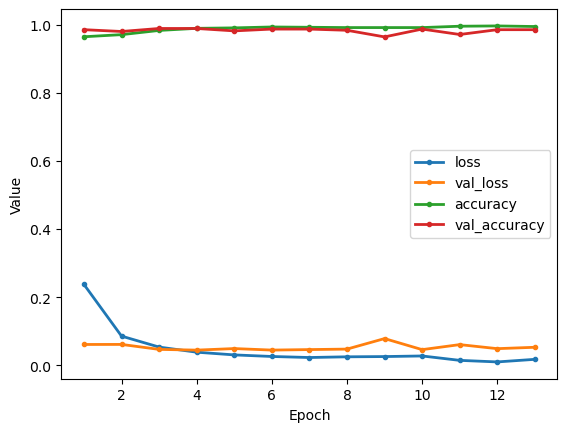

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1069,0.002364,0.0,0.002364,0.0,0.0,0.000000,0.0,0.0,0.002364,0.002364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1763,0.000000,0.0,0.000000,0.0,0.0,0.004237,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3468,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.002604,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2829, 8612)
X_test: (708, 8612)
y_train: (2829,)
y_test: (708,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,248,193 (8.58 MB)

 Trainable params: 2,248,193 (8.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 16s 473ms/step - accuracy: 0.4531 - loss: 0.6932

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4880 - loss: 0.6931   

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5011 - loss: 0.6919

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5411 - loss: 0.6886

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5816 - loss: 0.6818 - val_accuracy: 0.9258 - val_loss: 0.4657


Epoch 2/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9531 - loss: 0.4611

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9724 - loss: 0.4010 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9732 - loss: 0.3461

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9746 - loss: 0.3020

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9756 - loss: 0.2696 - val_accuracy: 0.9717 - val_loss: 0.0971


Epoch 3/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0104

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9932 - loss: 0.0295 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9937 - loss: 0.0279

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9938 - loss: 0.0274

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9941 - loss: 0.0261 - val_accuracy: 0.9876 - val_loss: 0.0454


Epoch 4/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0037

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0048 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0053

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0055

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.9894 - val_loss: 0.0436


Epoch 5/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0011

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6021e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0012    

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0019

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9841 - val_loss: 0.0504


Epoch 6/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0041

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0022 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0018

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9894 - val_loss: 0.0356


Epoch 7/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0011

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5033e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6464e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2370e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.3555e-04 - val_accuracy: 0.9894 - val_loss: 0.0486


Epoch 8/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.2929e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3444e-04 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7168e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8175e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9075e-04 - val_accuracy: 0.9876 - val_loss: 0.0497


Epoch 9/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.9159e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3287e-04 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5903e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7889e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7858e-04 - val_accuracy: 0.9894 - val_loss: 0.0409


Epoch 10/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.2285e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8831e-04 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3420e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3986e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2053e-04 - val_accuracy: 0.9859 - val_loss: 0.0573


Epoch 11/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0023

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0986e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6839e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5737e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9308e-04 - val_accuracy: 0.9894 - val_loss: 0.0505


Epoch 12/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.9790e-05

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1521e-04 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2230e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2451e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2364e-04 - val_accuracy: 0.9876 - val_loss: 0.0602


Epoch 13/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.2206e-05

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6146e-04 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5453e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5177e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4875e-04 - val_accuracy: 0.9876 - val_loss: 0.0583


Epoch 14/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.6748e-05

10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6105e-05 

19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1669e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2486e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2541e-04 - val_accuracy: 0.9859 - val_loss: 0.0651



[Train Accuracy: 100.00% - Test Accuracy: 99.29%]


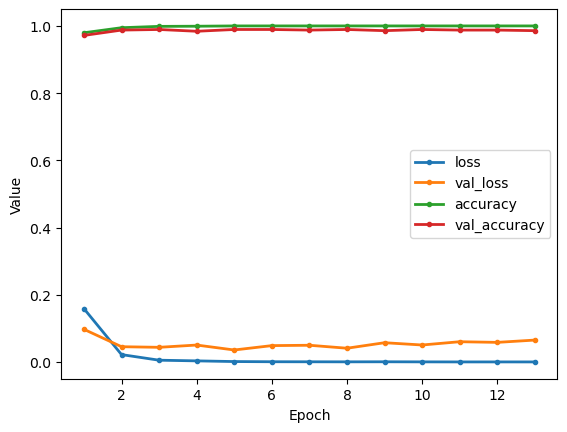

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1069,0.0,0.0,0.00237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1763,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3468,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      33,791,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,832,449 (129.06 MB)

 Trainable params: 33,832,449 (129.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 23s 667ms/step - accuracy: 0.5312 - loss: 0.6931

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5078 - loss: 0.6932 

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5000 - loss: 0.6932

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.4990 - loss: 0.6931

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5005 - loss: 0.6930

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5000 - loss: 0.6930

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5067 - loss: 0.6929

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5158 - loss: 0.6928

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5257 - loss: 0.6926

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5359 - loss: 0.6925

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5444 - loss: 0.6923

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5518 - loss: 0.6921

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5591 - loss: 0.6919

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5665 - loss: 0.6916

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5736 - loss: 0.6913

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5806 - loss: 0.6910

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5877 - loss: 0.6907

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5948 - loss: 0.6904

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.6018 - loss: 0.6900

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.6086 - loss: 0.6896

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.6152 - loss: 0.6892

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6216 - loss: 0.6887

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6277 - loss: 0.6882

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6337 - loss: 0.6876

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6394 - loss: 0.6870

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6450 - loss: 0.6863

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6503 - loss: 0.6856

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6553 - loss: 0.6849

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6603 - loss: 0.6840

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6650 - loss: 0.6832

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6697 - loss: 0.6822

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6741 - loss: 0.6813

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6785 - loss: 0.6802

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6827 - loss: 0.6791

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6867 - loss: 0.6779

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6906 - loss: 0.6768

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.6943 - loss: 0.6757 - val_accuracy: 0.9735 - val_loss: 0.4242


Epoch 2/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9688 - loss: 0.4302

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9648 - loss: 0.4227

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9661 - loss: 0.4147

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9688 - loss: 0.4078

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9700 - loss: 0.4009

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9715 - loss: 0.3934

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9730 - loss: 0.3868

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9742 - loss: 0.3805

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9752 - loss: 0.3741

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9756 - loss: 0.3683

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9759 - loss: 0.3626

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9761 - loss: 0.3571

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9763 - loss: 0.3516

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9767 - loss: 0.3460

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9770 - loss: 0.3405

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9774 - loss: 0.3350

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9778 - loss: 0.3296

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9783 - loss: 0.3244

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9786 - loss: 0.3194

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9788 - loss: 0.3145

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9790 - loss: 0.3098

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9793 - loss: 0.3051

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9795 - loss: 0.3006

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9797 - loss: 0.2963

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9798 - loss: 0.2921

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9800 - loss: 0.2880

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9802 - loss: 0.2839

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9804 - loss: 0.2800

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9805 - loss: 0.2762

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9807 - loss: 0.2725

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9809 - loss: 0.2690

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9810 - loss: 0.2655

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9812 - loss: 0.2622

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9814 - loss: 0.2589

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9815 - loss: 0.2557

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9816 - loss: 0.2527

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9818 - loss: 0.2498 - val_accuracy: 0.9912 - val_loss: 0.0369


Epoch 3/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9844 - loss: 0.0228

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9883 - loss: 0.0190

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9887 - loss: 0.0205

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9896 - loss: 0.0204

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9904 - loss: 0.0198

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9911 - loss: 0.0190

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9918 - loss: 0.0183

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9923 - loss: 0.0176

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9928 - loss: 0.0170

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9932 - loss: 0.0164

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9936 - loss: 0.0159

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9939 - loss: 0.0154

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9942 - loss: 0.0150

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9944 - loss: 0.0146

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9946 - loss: 0.0143

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9949 - loss: 0.0140

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9951 - loss: 0.0137

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9952 - loss: 0.0134

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9954 - loss: 0.0133

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9954 - loss: 0.0132

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9955 - loss: 0.0132

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9956 - loss: 0.0131

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9957 - loss: 0.0131

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9957 - loss: 0.0130

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9958 - loss: 0.0129

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9959 - loss: 0.0129

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9959 - loss: 0.0128

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9960 - loss: 0.0128

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9961 - loss: 0.0127

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9961 - loss: 0.0127

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9962 - loss: 0.0126

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9962 - loss: 0.0126

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9963 - loss: 0.0125

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9964 - loss: 0.0125

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9964 - loss: 0.0124

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9965 - loss: 0.0124

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9965 - loss: 0.0123 - val_accuracy: 0.9929 - val_loss: 0.0257


Epoch 4/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0015

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0015

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0016

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0023

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0025

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0027

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 0.0028

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0028

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0028

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0028

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0028

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0029

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0029

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0029

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0029

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0029

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0029

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0028

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0028

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0028

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0028

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0028

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0028

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0027

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0027

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0027

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0027

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0027

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0027

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0027

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0026

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0026

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0026

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0026

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0026

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0026

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9929 - val_loss: 0.0271


Epoch 5/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.6538e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 9.2263e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 9.5364e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 9.6132e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 9.6866e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 9.7570e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 9.7424e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 9.6975e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 9.6562e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 9.6464e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 9.6420e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 9.6257e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 9.6099e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 9.5948e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 9.5902e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 9.5728e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 9.5570e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.5468e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.5376e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.5235e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.4997e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.4924e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.4834e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.4744e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.4625e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.4711e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 9.4851e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 9.4972e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 9.5064e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 9.5121e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 9.5144e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 9.5260e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 9.5362e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 9.5544e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 9.5674e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 9.5810e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 9.5939e-04 - val_accuracy: 0.9929 - val_loss: 0.0290


Epoch 6/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.4674e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 1.0000 - loss: 5.7769e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 5.6330e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 5.6790e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 5.6522e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 5.5945e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 5.5144e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 5.4638e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 5.4385e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 5.4420e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 5.4385e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 5.4318e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 5.4280e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.4227e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.4241e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 5.4232e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 5.4187e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.4149e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.4070e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.3998e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.3891e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.3788e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.3653e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.3618e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.3614e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.3607e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 5.3565e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 5.3508e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 5.3435e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 5.3333e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 5.3229e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 5.3124e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 5.2997e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 5.2991e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 5.2969e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 5.2941e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.2915e-04 - val_accuracy: 0.9929 - val_loss: 0.0300


Epoch 7/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.4737e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 3.9369e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 1.0000 - loss: 3.7032e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 3.6614e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 3.5673e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 3.5199e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 3.4919e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5086e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 3.5176e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5197e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5186e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5348e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5503e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5549e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5513e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5577e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 3.5818e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 1.0000 - loss: 3.5996e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 3.6144e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 3.6264e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 3.6351e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 3.6425e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 3.6468e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 3.6551e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 3.6598e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 3.6815e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 3.6993e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 3.7135e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 3.7249e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 3.7402e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 3.7550e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 3.7721e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 3.7873e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 3.8009e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 3.8144e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 3.8420e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 3.8681e-04 - val_accuracy: 0.9929 - val_loss: 0.0291


Epoch 8/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.4847e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 3.6422e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 3.4395e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 3.2742e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 3.1810e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 3.1312e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 3.3667e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 3.5326e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 3.7090e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 3.8263e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 3.9368e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 4.0197e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 4.0805e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 4.1401e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 4.2182e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 4.2883e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 4.3680e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 4.4363e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 4.4922e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 4.5383e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 4.5892e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 4.6316e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 4.6642e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 4.6877e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 4.7068e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 4.7200e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7283e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7340e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7377e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7391e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7379e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7337e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7282e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7218e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 4.7137e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 4.7069e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.7005e-04 - val_accuracy: 0.9929 - val_loss: 0.0352


Epoch 9/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.6126e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 1.0000 - loss: 2.1482e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 2.2240e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 2.2840e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.3540e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 2.3851e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.3896e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.3722e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.3724e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.3700e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.3549e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.3375e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 2.3201e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.3074e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.2939e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 2.2919e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 2.2905e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 2.2855e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 2.2816e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 2.2746e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 2.2686e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 2.2644e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 2.2584e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 2.2529e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 2.2467e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 2.2399e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2340e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2268e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2224e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2168e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2103e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2046e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2433e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2782e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3093e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.3381e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.3652e-04 - val_accuracy: 0.9929 - val_loss: 0.0314


Epoch 10/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9648e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 1.9810e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.1797e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.2536e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.2698e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 2.2708e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.2506e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.2643e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.2660e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.2626e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.2518e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.2389e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.2225e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.2388e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 2.2478e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 2.2728e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 2.2931e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.3089e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.3194e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.3273e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.3318e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.3339e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.3344e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 2.3334e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 2.3317e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 2.3292e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3260e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3236e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3218e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3186e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3159e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 2.3178e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3184e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3182e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3179e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.3172e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.3165e-04 - val_accuracy: 0.9929 - val_loss: 0.0327


Epoch 11/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.0495e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.3825e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.3988e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.4166e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.4437e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.5285e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.5682e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.5826e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.5891e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.5954e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.5947e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.5900e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.5834e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.5854e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.5922e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.5969e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.5997e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 1.6031e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 1.6044e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 1.6060e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.6080e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.6088e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.6087e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.6086e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.6070e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.6062e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.6045e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.6037e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.6027e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.6009e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.5983e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.5950e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.5931e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.5906e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.5897e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.5886e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.5875e-04 - val_accuracy: 0.9929 - val_loss: 0.0374


Epoch 12/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 7.4822e-05

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 7.8092e-05

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 8.8727e-05

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 9.3765e-05

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 9.7823e-05

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 1.0002e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 1.0127e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 1.0176e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 1.0183e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 1.0168e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.0144e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0175e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0224e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.0246e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0261e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.0285e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.0292e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.0286e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.0316e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.0339e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0362e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.0375e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.0387e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.0409e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0423e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0443e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.0457e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.0486e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0508e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0526e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0540e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0557e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0568e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0584e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.0596e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.0606e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.0615e-04 - val_accuracy: 0.9912 - val_loss: 0.0384


Epoch 13/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 1.0000 - loss: 1.5307e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.5167e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.4361e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.3808e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.3556e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.3316e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3005e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.2720e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.2569e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.2382e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.2208e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.2028e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.1895e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.1750e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.1613e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.1497e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.1384e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.1273e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.1160e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1122e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.1089e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1070e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.1047e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.1025e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.1000e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0972e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.0943e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0919e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0892e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0861e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0829e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0794e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0755e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0719e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.0682e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.0646e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.0611e-04 - val_accuracy: 0.9912 - val_loss: 0.0398



[Train Accuracy: 100.00% - Test Accuracy: 98.73%]


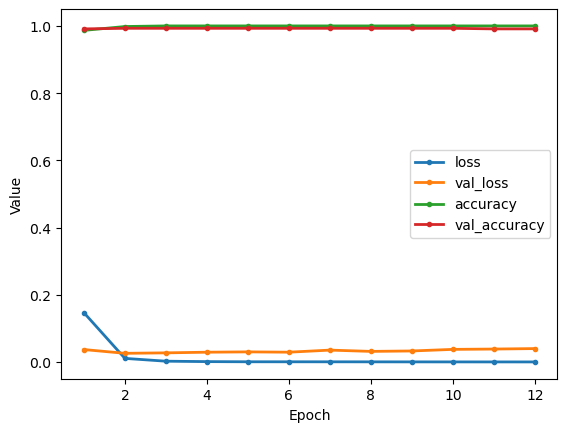

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 7/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

13/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

 7/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

13/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [25]:
report.save()

Report saved as Output/Reports/E2F__DP/report_CKJITT6R.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################